## Solução da Equação do Calor 1D

Este notebook demonstra a solução da equação diferencial parcial (EDP) do calor em uma dimensão:

$$ \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2} $$

Onde:
- $u(x, t)$ é a temperatura na posição $x$ e no tempo $t$.
- $\alpha$ é a difusividade térmica do material.

### Método das Linhas (Method of Lines - MOL)

O método consiste em discretizar a(s) variável(is) espacial(is), neste caso $x$, transformando a EDP em um sistema de Equações Diferenciais Ordinárias (EDOs) no tempo $t$. A derivada espacial de segunda ordem é aproximada usando a fórmula de diferenças finitas centrada:

$$ \frac{\partial^2 u}{\partial x^2} \bigg|_{x=x_i} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta x)^2} $$

Substituindo na equação original para cada ponto $i$ do nosso domínio (exceto as fronteiras), obtemos um sistema de EDOs:

$$ \frac{du_i}{dt} = \alpha \frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta x)^2} $$

Este sistema pode ser resolvido utilizando um solver de EDOs, como o `solve_ivp` da biblioteca SciPy.

### Importação das Bibliotecas

Importamos as bibliotecas necessárias para cálculo numérico (`numpy`), integração de EDOs (`scipy.integrate`) e visualização de dados (`matplotlib`).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

### Definição dos Parâmetros

Definimos os parâmetros físicos e numéricos do problema.
- **Parâmetros Físicos**: Comprimento da barra, difusividade térmica e tempo total de simulação.
- **Condições de Contorno**: Temperaturas fixas nas extremidades da barra (Dirichlet).
- **Parâmetros Numéricos**: Número de pontos para a discretização do espaço.

In [2]:
# Parâmetros Físicos
length = 1.0  # Comprimento da barra [m]
alpha = 0.5  # Difusividade térmica [m^2/s]
t_final = 1.0  # Tempo final da simulação [s]

# Condições de Contorno (Dirichlet)
T_left = 1.0  # Temperatura na fronteira esquerda (x=0) [°C]
T_right = 0.0  # Temperatura na fronteira direita (x=L) [°C]

# Parâmetros Numéricos
nx = 101  # Número de pontos no espaço (incluindo as fronteiras)
nt = 101  # Número de pontos no tempo

# Discretização Espacial
x_grid = np.linspace(0, length, nx)
dx = length / (nx - 1)

### Condição Inicial

Definimos a distribuição de temperatura na barra no instante $t=0$. Neste caso, vamos assumir que a barra está inicialmente a uma temperatura de 0°C, exceto nas fronteiras, que já assumem seus valores definidos.

In [3]:
# Vetor da condição inicial para todos os pontos
u0 = np.zeros(nx)

# Aplicando as condições de contorno na condição inicial
u0[0] = T_left
u0[-1] = T_right

# O solver de EDOs irá operar apenas nos pontos internos da barra
u0_interior = u0[1:-1]

### Função do Sistema de EDOs

Esta é a função principal do Método das Linhas. Ela calcula a derivada temporal `du/dt` para cada ponto *interno* da barra, baseada na aproximação por diferenças finitas da derivada espacial.

In [4]:
def heat_equation_mol(t, u_interior, alpha, dx, T_left, T_right):
    """
    Define o sistema de EDOs para a equação do calor 1D.

    Args:
        t (float): Tempo atual (não utilizado diretamente, mas requerido pelo solver).
        u_interior (np.array): Vetor com as temperaturas nos pontos internos.
        alpha (float): Difusividade térmica.
        dx (float): Passo no espaço.
        T_left (float): Temperatura da fronteira esquerda.
        T_right (float): Temperatura da fronteira direita.

    Returns:
        np.array: Vetor com os valores de d(u_interior)/dt.
    """
    n_interior = len(u_interior)

    dudt = np.zeros(n_interior)

    # Calcula a derivada para o primeiro ponto interno (vizinho da fronteira esquerda)
    dudt[0] = alpha * (u_interior[1] - 2 * u_interior[0] + T_left) / dx**2

    # Calcula a derivada para os pontos centrais
    for i in range(1, n_interior - 1):
        dudt[i] = (
            alpha * (u_interior[i + 1] - 2 * u_interior[i] + u_interior[i - 1]) / dx**2
        )

    # Calcula a derivada para o último ponto interno (vizinho da fronteira direita)
    dudt[-1] = alpha * (T_right - 2 * u_interior[-1] + u_interior[-2]) / dx**2

    return dudt

### Solução do Sistema de EDOs

Utilizamos a função `solve_ivp` do SciPy para integrar o sistema de EDOs no tempo, partindo da condição inicial `u0_interior`.

In [5]:
# Intervalo de tempo para a integração
t_span = [0, t_final]

# Pontos no tempo onde queremos a solução
t_eval = np.linspace(t_span[0], t_span[1], nt)

# Chamada ao solver de EDOs
sol = solve_ivp(
    fun=heat_equation_mol,
    t_span=t_span,
    y0=u0_interior,
    args=(alpha, dx, T_left, T_right),
    t_eval=t_eval,
)

# A solução contém os resultados para os pontos internos
U_sol = sol.y.T

left_boundary = np.full((nt, 1), T_left)
right_boundary = np.full((nt, 1), T_right)

U_sol = np.hstack([left_boundary, U_sol, right_boundary])

### Visualização dos Resultados

Plotamos a distribuição de temperatura ao longo da barra em diferentes instantes de tempo para visualizar a evolução do calor.

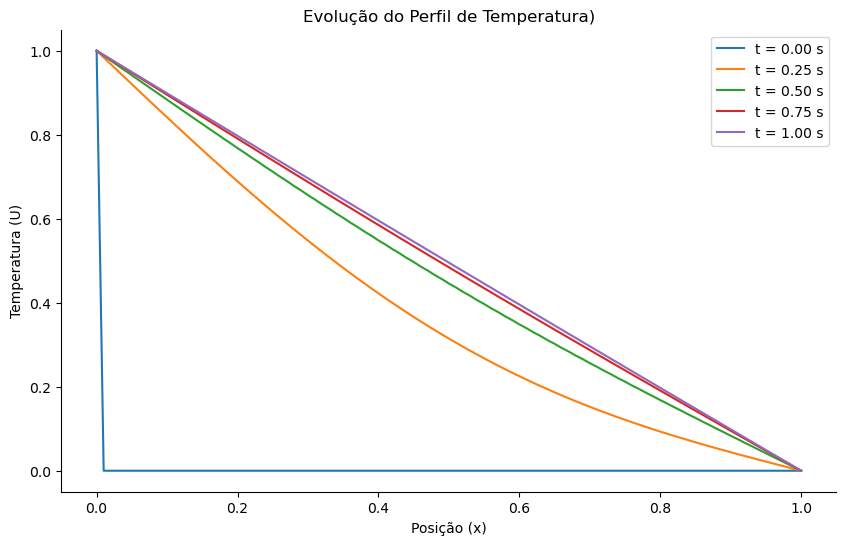

In [6]:
# Perfis de Temperatura ao Longo do Tempo

fig, ax = plt.subplots(figsize=(10, 6))

idx_time = [0, nt // 4, nt // 2, 3 * nt // 4, nt - 1]  # Pega 5 instantes de tempo
for i, t_idx in enumerate(idx_time):
    ax.plot(x_grid, U_sol[t_idx, :], label=f"t = {t_eval[t_idx]:.2f} s")

ax.set_title("Evolução do Perfil de Temperatura)", fontsize=12)
ax.set_xlabel("Posição (x)", fontsize=10)
ax.set_ylabel("Temperatura (U)", fontsize=10)
ax.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#### Visualização 2D (Mapa de Calor)

Outra forma interessante de visualizar os resultados é através de um mapa de calor (ou *heatmap*), onde o eixo x representa a posição, o eixo y o tempo, e a cor representa a temperatura.

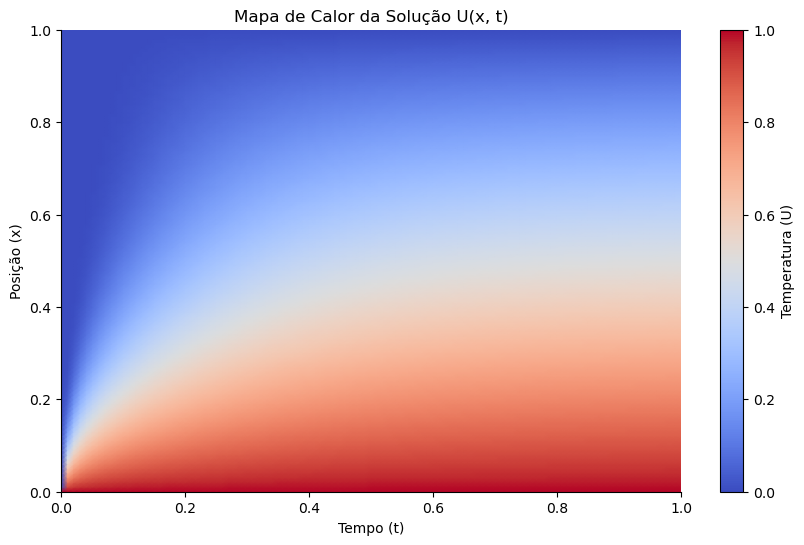

In [ ]:
# Mapa de Calor U(x, t)

T_grid, X_grid = np.meshgrid(t_eval, x_grid)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.pcolormesh(T_grid, X_grid, U_sol.T, cmap="coolwarm", shading="gouraud")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Temperatura (U)", fontsize=10)

ax.set_title("Mapa de Calor da Solução U(x, t)", fontsize=12)
ax.set_xlabel("Tempo (t)", fontsize=10)
ax.set_ylabel("Posição (x)", fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

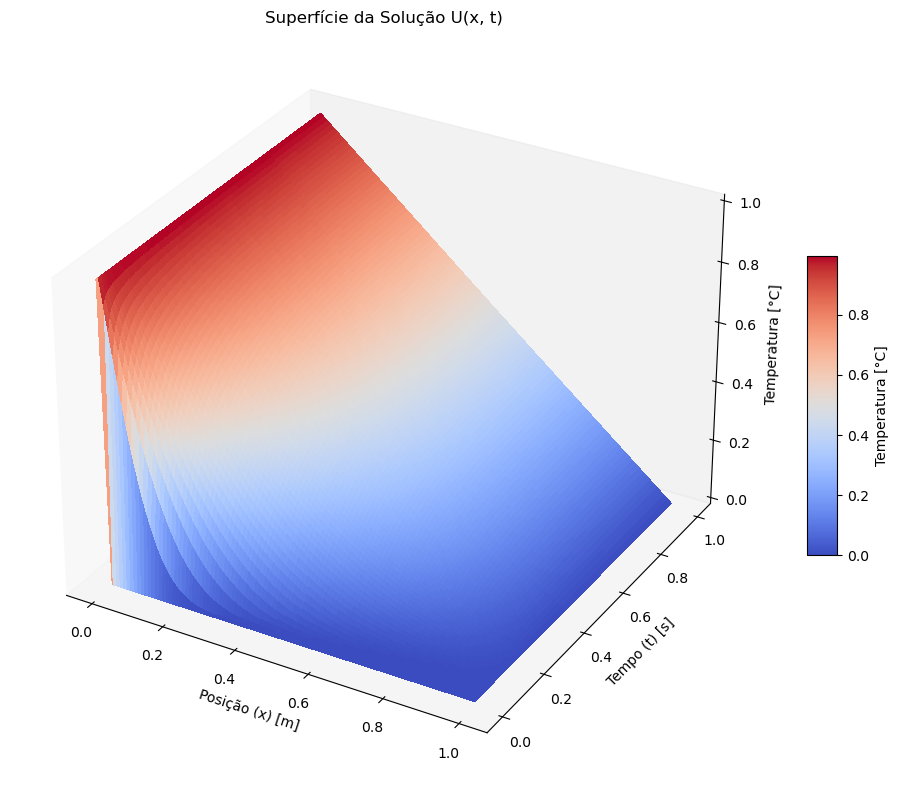

In [ ]:
# Superfície U(x, t)

T, X = np.meshgrid(t_eval, x_grid)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    X, T, U_sol.T, cmap="coolwarm", rstride=1, cstride=1, antialiased=False
)
fig.colorbar(surf, shrink=0.4, aspect=10, label="Temperatura [°C]")

ax.set_title("Superfície da Solução U(x, t)", fontsize=12)
ax.set_xlabel("Posição (x) [m]", fontsize=10)
ax.set_ylabel("Tempo (t) [s]", fontsize=10)
ax.set_zlabel("Temperatura [°C]", fontsize=10)
ax.grid(False)

plt.tight_layout()

### Exportando os Resultados

In [ ]:
# Achatar (flatten) todas as matrizes para vetores 1D
x_flat = X.flatten()
t_flat = T.flatten()
k_flat = U_sol.flatten()

# Empilhar os vetores como colunas
data_np = np.column_stack([x_flat, t_flat, k_flat])

print("Shape do resultado:", data_np.shape)

data = pd.DataFrame(data_np, columns=["position", "time", "temperature"])
print("Resultado:")
display(data)

data.to_csv("../data/heat_equation_dirichlet.csv")

Shape do resultado: (10201, 3)
Resultado:


,position,time,temperature
0,0.0,0.00,1.000000
1,0.0,0.01,0.000000
2,0.0,0.02,0.000000
3,0.0,0.03,0.000000
4,0.0,0.04,0.000000
...,...,...,...
10196,1.0,0.96,0.039437
10197,1.0,0.97,0.029560
10198,1.0,0.98,0.019718
10199,1.0,0.99,0.009853
